In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
from joblib import load, dump

In [2]:
# Paths
BASE_DIR = '../'
#PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/predecir.parquet")
#PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/predecir_producto.parquet")
PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/1_c_producto_predecir.parquet")
#PATH_TO_ESCALA = os.path.join(BASE_DIR, "Dataset/factores_escala_por_producto.csv")
#PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/predecir_producto_201910.parquet")
PATH_TO_MODELS = os.path.join(BASE_DIR, "LGBM/models")
#PATH_TO_MODELS_BAJO_VOL = os.path.join(BASE_DIR, "LGBM/models/bajos")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "LGBM/optuna/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "LGBM/optuna/optuna_artifacts")

SEED = 42

In [3]:
# Datos Tabulares
dataset = pd.read_parquet(PATH_TO_PREDICT)
productos_a_predecir= pd.read_csv(os.path.join(BASE_DIR, "Dataset/product_id_apredecir201912.txt"), sep='\t')

In [4]:
dataset = dataset.loc[dataset['periodo'] == 201912]

In [5]:
del dataset['ultima_tn']
del dataset['cluster_500']
del dataset['cluster_50']
del dataset['cluster_100']
del dataset['cluster_10']
del dataset['cluster_3']
del dataset['cluster_2']
del dataset['prod_season_yearly']
del dataset['cat_season_yearly']
del dataset['total_season_yearly']
del dataset['prod_trend']
del dataset['cat_trend']
del dataset['total_trend']

In [6]:
dataset.head()

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,otros_avg_lag10,otros_avg_lag11,otros_avg_lag12,otros_avg_lag13,timestamp,tn_pred_auto,n_meses_hist,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn
1,201912,20001,1505.0,2.519531,15.929688,597,407,1650.0,201701,201912,...,95.2500,95.1250,92.7500,127.8750,2019-12-01,1464.0,34.0,-41.250000,-0.027420,0.972656
3,201912,20002,1087.0,1.821289,17.156250,597,217,1092.0,201701,201912,...,101.0625,95.3125,106.0625,129.1250,2019-12-01,1194.0,34.0,106.687500,0.098145,1.098633
5,201912,20003,892.5,1.495117,8.257812,597,314,970.0,201701,201912,...,65.5625,66.8125,71.5625,94.5000,2019-12-01,876.5,34.0,-16.015625,-0.017944,0.981934
7,201912,20004,638.0,1.068359,4.445312,597,313,678.5,201701,201912,...,75.1250,80.5625,77.0000,106.4375,2019-12-01,744.0,34.0,106.000000,0.166138,1.166016
9,201912,20005,593.0,0.993652,5.593750,597,269,630.5,201701,201912,...,76.1250,85.0000,83.3125,116.1875,2019-12-01,707.5,34.0,114.437500,0.192993,1.193359


In [7]:
dataset.shape

(927, 298)

In [8]:
#unir en un solo dataset
dataset = (
    dataset
    .merge(productos_a_predecir, on='product_id', how='inner')
)

In [9]:
#del dataset['volumen_alto']

In [10]:
dataset.shape

(780, 298)

In [11]:
def tipos_correctos(df, verbose=True):
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        #   - Datetime
        # 1) Datetime → int64 (ns) → float32
        if pd.api.types.is_datetime64_any_dtype(col_type):
            # view() extrae los nanosegundos desde epoch
            df[col] = df[col].view('int64').astype('float32')
            continue


        # Solo nos ocupamos de numéricos
        if not pd.api.types.is_numeric_dtype(col_type):
            if not pd.api.types.is_categorical_dtype(col_type):
                df[col] = df[col].astype('category')
            continue

        c_min, c_max = df[col].min(), df[col].max()
        has_na = df[col].isnull().any()

        # --- ENTEROS ---
        if pd.api.types.is_integer_dtype(col_type):
            # 1) Sin nulos → numpy ints
            if not has_na:
                if c_min >= np.iinfo(np.int8).min  and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)


        # --- FLOTANTES ---
        else:
            df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Uso de memoria inicial del DataFrame: {start_mem:.2f} MB')
        print(f'Uso de memoria final del DataFrame:   {end_mem:.2f} MB')
        print(f'Memoria reducida en un {(100*(start_mem-end_mem)/start_mem):.2f}%')
    return df

In [12]:
dataset = tipos_correctos(dataset)

Uso de memoria inicial del DataFrame: 0.49 MB
Uso de memoria final del DataFrame:   0.87 MB
Memoria reducida en un -76.08%


C:\Users\diana\AppData\Local\Temp\ipykernel_5688\57235330.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(col_type):
C:\Users\diana\AppData\Local\Temp\ipykernel_5688\57235330.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(col_type):
C:\Users\diana\AppData\Local\Temp\ipykernel_5688\57235330.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(col_type):
C:\Users\diana\AppData\Local\Temp\ipykernel_5688\57235330.py:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
 

In [13]:
pred=dataset.copy()

In [14]:
pred.head(20)

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,otros_avg_lag10,otros_avg_lag11,otros_avg_lag12,otros_avg_lag13,timestamp,tn_pred_auto,n_meses_hist,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn
0,201912,20001,1505.000,2.519531,15.929688,597,407,1650.000,201701,201912,...,95.25000,95.12500,92.75000,127.87500,1.575158e+18,1464.00,34.0,-41.250000,-0.027420,0.972656
1,201912,20002,1087.000,1.821289,17.156250,597,217,1092.000,201701,201912,...,101.06250,95.31250,106.06250,129.12500,1.575158e+18,1194.00,34.0,106.687500,0.098145,1.098633
2,201912,20003,892.500,1.495117,8.257812,597,314,970.000,201701,201912,...,65.56250,66.81250,71.56250,94.50000,1.575158e+18,876.50,34.0,-16.015625,-0.017944,0.981934
3,201912,20004,638.000,1.068359,4.445312,597,313,678.500,201701,201912,...,75.12500,80.56250,77.00000,106.43750,1.575158e+18,744.00,34.0,106.000000,0.166138,1.166016
4,201912,20005,593.000,0.993652,5.593750,597,269,630.500,201701,201912,...,76.12500,85.00000,83.31250,116.18750,1.575158e+18,707.50,34.0,114.437500,0.192993,1.193359
5,201912,20006,417.250,0.698730,4.679688,597,250,439.750,201701,201912,...,90.18750,94.43750,85.68750,89.25000,1.575158e+18,478.50,34.0,61.281250,0.146851,1.146484
6,201912,20007,390.500,0.653809,4.164062,597,338,398.750,201701,201912,...,88.12500,80.18750,88.18750,121.93750,1.575158e+18,431.00,34.0,40.531250,0.103760,1.103516
7,201912,20008,195.375,0.327148,1.662109,597,171,225.375,201701,201912,...,68.43750,61.15625,52.87500,59.78125,1.575158e+18,434.75,34.0,239.375000,1.224609,2.224609
8,201912,20009,495.000,0.829102,5.867188,597,297,523.000,201701,201912,...,119.37500,117.68750,118.68750,162.87500,1.575158e+18,499.00,34.0,3.960938,0.008003,1.007812
9,201912,20010,359.500,0.602539,4.742188,597,172,440.500,201701,201912,...,131.37500,125.43750,115.00000,144.75000,1.575158e+18,430.25,34.0,70.625000,0.196411,1.196289


# Predicción

In [15]:
class LGBMEnsemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.mean([model.predict(X) for model in self.models], axis=0)
        return preds

# Cargar todos los modelos .joblib en la carpeta
ensemble_models = [
    load(os.path.join(PATH_TO_MODELS, fname))
    for fname in os.listdir(PATH_TO_MODELS)
    if fname.endswith('.joblib') and fname.startswith('lgb_final_model_todo_seed')
]

# Crear el modelo de ensamble
ensemble_model = LGBMEnsemble(ensemble_models)

# Guardar el ensamble
path_guardado = os.path.join(PATH_TO_MODELS, "modelo_lgbm_ensemble.joblib")
dump(ensemble_model, path_guardado)
print(f"✅ Ensamble guardado en: {path_guardado}")


✅ Ensamble guardado en: ../LGBM/models\modelo_lgbm_ensemble.joblib


In [16]:
ensemble_models = [
    load(os.path.join(PATH_TO_MODELS, fname))
    for fname in os.listdir(PATH_TO_MODELS)
    if fname.endswith('.joblib') and fname.startswith('lgb_final_model_todo_seed')
]

print(f"Modelos encontrados: {len(ensemble_models)}")

if not ensemble_models:
    raise ValueError("❌ No se encontraron modelos con prefijo 'lgb_model_' en la carpeta.")

ensemble_model = LGBMEnsemble(ensemble_models)

dump(ensemble_model, path_guardado)
print(f"✅ Ensemble guardado en: {path_guardado}")

Modelos encontrados: 99
✅ Ensemble guardado en: ../LGBM/models\modelo_lgbm_ensemble.joblib


In [17]:
#predicción con ensemble

modelo = load(os.path.join(PATH_TO_MODELS, f"modelo_lgbm_ensemble.joblib"))
# Realizar predicciones
pred["clase"] = modelo.predict(pred)

In [18]:
pred.sample(5)

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,otros_avg_lag11,otros_avg_lag12,otros_avg_lag13,timestamp,tn_pred_auto,n_meses_hist,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn,clase
342,201912,20426,8.054688,0.013489,0.109863,597,108,8.054688,201701,201912,...,106.9375,113.8750,153.37500,1.575158e+18,7.937500,34.0,-0.115479,-0.014336,0.985840,0.152365
741,201912,21168,0.140869,0.000236,0.001681,597,41,0.140869,201902,201912,...,NaN,NaN,NaN,1.575158e+18,0.512207,34.0,0.371582,2.636719,3.636719,0.852155
313,201912,20385,7.472656,0.012520,0.112305,597,100,7.472656,201701,201912,...,20.0625,16.0000,18.59375,1.575158e+18,10.140625,34.0,2.669922,0.357178,1.357422,3.082056
62,201912,20069,136.625000,0.228882,1.451172,597,225,139.625000,201701,201912,...,132.0000,119.5625,153.50000,1.575158e+18,116.125000,34.0,-20.500000,-0.150024,0.850098,-6.902063
95,201912,20108,58.343750,0.097717,0.468994,597,251,58.343750,201701,201912,...,94.1250,92.2500,126.68750,1.575158e+18,76.250000,34.0,17.890625,0.306641,1.306641,2.841541


# Shapley

In [19]:
import shap
import lightgbm as lgb

In [20]:
model_dir = PATH_TO_MODELS
model_filename = 'lgb_final_model_todo_seed_999.joblib'
full_model_path = os.path.join(model_dir, model_filename)

In [21]:
modelo2 = load(full_model_path)

In [22]:
# Features usadas por el modelo
features_model = modelo2.feature_name()

# Features presentes en pred
features_pred = pred.columns.tolist()

# Diferencias
missing_in_pred = list(set(features_model) - set(features_pred))
extra_in_pred = list(set(features_pred) - set(features_model))

print("Faltan en pred:", missing_in_pred)
print("Sobran en pred:", extra_in_pred)

Faltan en pred: []
Sobran en pred: ['clase']


In [23]:
features = modelo2.feature_name()


In [24]:
explainer = shap.Explainer(modelo2)

In [25]:
pred_sh=pred.copy()
pred_sh=pred_sh.drop(columns=['clase']).copy()

In [26]:
mask = pred_sh['product_id'].isin([21276])  # o los ids concretos

X_chico = pred_sh[mask]
print(X_chico.shape)
X_chico.head()
shap_values = explainer(X_chico)

(1, 298)


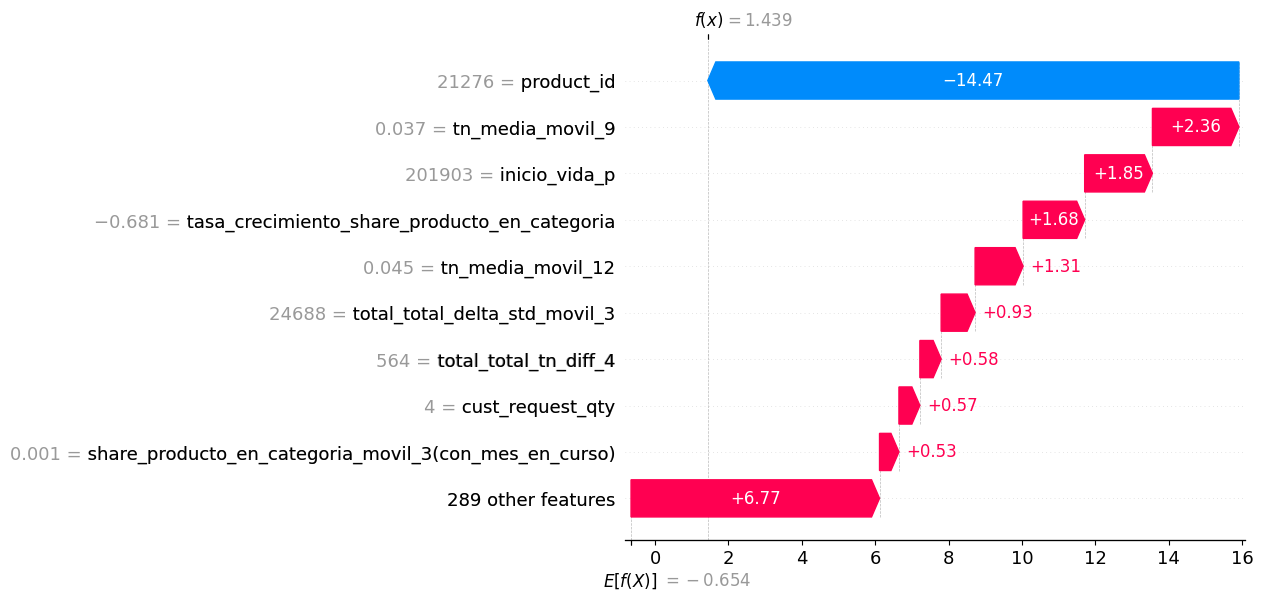

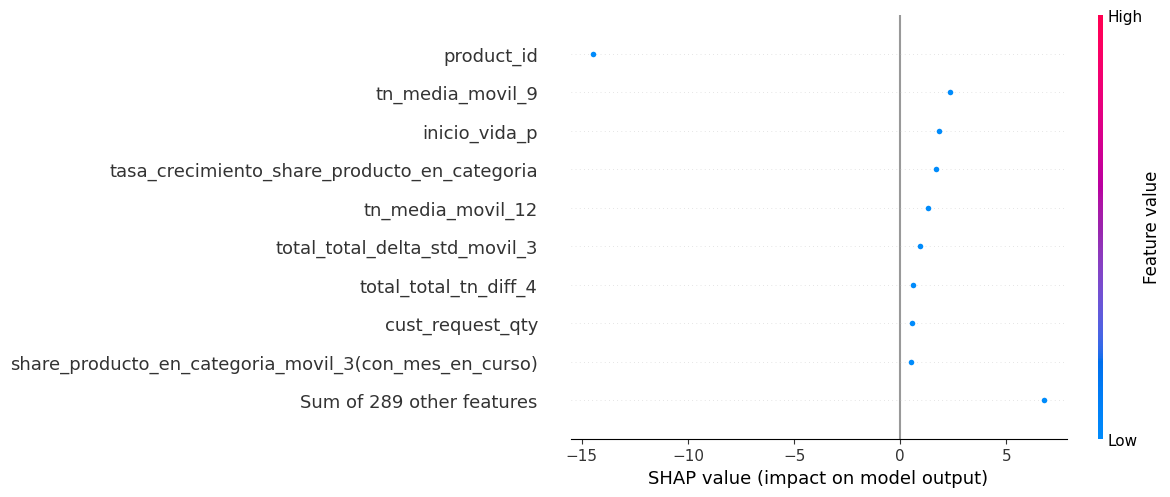

In [27]:
# Para una sola fila:
shap.plots.waterfall(shap_values[0])

# Para un resumen global de los productos chicos:
shap.plots.beeswarm(shap_values)

# armar prediccion

In [28]:
pred["tn_predicha"]=pred["clase"]+pred["producto_total_tn"]
pred.loc[pred['tn_predicha'] < 0, 'tn_predicha'] = 0


In [29]:
pred.rename(columns={"tn_predicha": "tn"}, inplace=True)

In [30]:
pred[['product_id', 'tn']].to_csv('prediccion.csv', index=False)